# Fashion-MNIT实践

## 参数配置

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

In [2]:
device =torch.device("cuda"if torch.cuda.is_available() else 'cpu')

batch_size=64
new_workers=4
lr=1e-4
epochs=15

## 数据导入

### 直接pytroch下载数据集

In [3]:
from torchvision import transforms

image_size=28
data_transforms=transforms.Compose([
    #transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [4]:
from torchvision import datasets

train_data=datasets.FashionMNIST('datasets',train=True,transform=data_transforms,download=True)
test_data=datasets.FashionMNIST('datasets',train=False,transform=data_transforms)

### 由CSV制作数据集

这里假设输入数据是pandas的dataframe

In [5]:
class FMDataset(Dataset):
    def __init__(self,df,transforms=None):
        self.df=df
        self.transforms=transforms
        self.images=df.iloc[:,1:].values.astype(np.uint8)
        self.labels=df.iloc[:,0].values
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image=self.images[index].reshape(28,28,1)
        label=int(self.labels[index])
        if(self.transforms is None):
           image=torch.tensor(image/255,dtype=torch.float)
        else:
            image=self.transforms(image)
        label=torch.tensor(label,dtype=torch.int)
        return image,label

# 上面还有一个train和test的分类没写
# train_df=pd.read_csv('...') 
# test_df=pd.read_csv('...')   
# train_data=FMDataset(train_df,data_transforms)
# test_data=FMDataset(test_df,data_transforms)

### 装载数据

In [6]:
# DataLoader参数pin_memory：增加运行速度消耗更多内存。这次先不用
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=new_workers,drop_last=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False,num_workers=new_workers)

torch.Size([64, 1, 28, 28]) torch.Size([64])


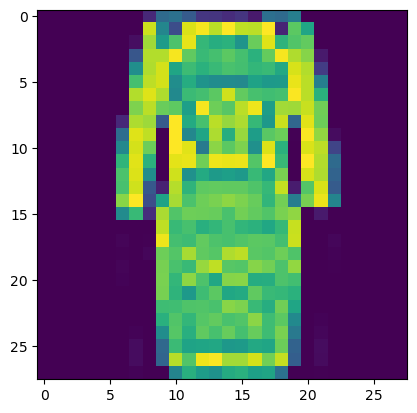

In [7]:
import matplotlib.pyplot as plt
image,label=next(iter(train_loader))
print(image.shape,label.shape)
plt.imshow(image[0][0])

## 模型构造

继承nn.Module，构造一个简单的卷积网络

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(1,32,5),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Dropout(0.3)
        )
        self.fc=nn.Sequential(
            nn.Linear(64*4*4,512),
            nn.ReLU(),
            nn.Linear(512,10)
        )

    def forward(self,x):
        x=self.conv(x)
        
        x=x.view(-1,64*4*4)
        x=self.fc(x)
        return x
   
    # 校验Conv的输出再判断self.fc如何设计
    def TestConv(self):
        print(self.conv(torch.rand([1,28,28])).shape)

Net().TestConv()
model=Net()
model=model.cuda()

torch.Size([64, 4, 4])


## 损失函数和优化器

In [9]:
criterian =nn.CrossEntropyLoss()

In [10]:
?nn.CrossEntropyLoss

Init signature:
nn.CrossEntropyLoss(
    weight: Optional[torch.Tensor] = None,
    size_average=None,
    ignore_index: int = -100,
    reduce=None,
    reduction: str = 'mean',
    label_smoothing: float = 0.0,
) -> None
Docstring:     
This criterion computes the cross entropy loss between input logits
and target.

It is useful when training a classification problem with `C` classes.
If provided, the optional argument :attr:`weight` should be a 1D `Tensor`
assigning weight to each of the classes.
This is particularly useful when you have an unbalanced training set.

The `input` is expected to contain the unnormalized logits for each class (which do `not` need
to be positive or sum to 1, in general).
`input` has to be a Tensor of size :math:`(C)` for unbatched input,
:math:`(minibatch, C)` or :math:`(minibatch, C, d_1, d_2, ..., d_K)` with :math:`K \geq 1` for the
`K`-dimensional case. The last being useful for higher dimension inputs, such
as computing cross entropy loss per-pixel f

In [11]:
optimizer=optim.Adam(model.parameters(),lr=lr)

## 训练

In [12]:
def train(epoch):
    model.train()
    train_loss=0
    for i,(data,label) in enumerate(train_loader):
        data,label=data.cuda(),label.cuda()
        optimizer.zero_grad()
        output=model(data)
        loss=criterian(output,label)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*data.size(0)
        
    train_loss=train_loss/len(train_loader.dataset)
    print('Epoch:{} \tTraining loss:{:.6f}'.format(epoch,train_loss))

In [13]:
def test(epoch):
    cro=0
    model.eval()
    test_loss=0
    for i,(data,label) in enumerate(test_loader):
        data,label=data.cuda(),label.cuda()
        output=model(data)
        loss=criterian(output,label)        
        test_loss+=loss.item()*data.size(0)        
        indexMax=output.argmax(1)
        # print(indexMax)
        # print(label)     
        cro+=torch.sum(indexMax-label == 0)

    test_loss=test_loss/len(test_loader.dataset)
    print('\t \tTesting loss:{:.6f} \t Acc:{:.3f}%'.format(test_loss,cro/len(test_loader.dataset)*100))

In [14]:
for i in range(30):
    train(i+1)
    test(i+1)

Epoch:1 	Training loss:0.829953
	 	Testing loss:0.597265 	 Acc:77.620%
Epoch:2 	Training loss:0.552917
	 	Testing loss:0.496204 	 Acc:82.070%
Epoch:3 	Training loss:0.481485
	 	Testing loss:0.443276 	 Acc:84.100%
Epoch:4 	Training loss:0.438916
	 	Testing loss:0.404987 	 Acc:85.920%
Epoch:5 	Training loss:0.407089
	 	Testing loss:0.378778 	 Acc:86.800%
Epoch:6 	Training loss:0.384405
	 	Testing loss:0.357965 	 Acc:87.380%
Epoch:7 	Training loss:0.366275
	 	Testing loss:0.345658 	 Acc:87.900%
Epoch:8 	Training loss:0.352008
	 	Testing loss:0.335416 	 Acc:87.980%
Epoch:9 	Training loss:0.337047
	 	Testing loss:0.328085 	 Acc:88.290%
Epoch:10 	Training loss:0.325990
	 	Testing loss:0.315274 	 Acc:88.720%
Epoch:11 	Training loss:0.317785
	 	Testing loss:0.310431 	 Acc:88.760%
Epoch:12 	Training loss:0.309761
	 	Testing loss:0.298708 	 Acc:89.160%
Epoch:13 	Training loss:0.298719
	 	Testing loss:0.299567 	 Acc:89.040%
Epoch:14 	Training loss:0.294529
	 	Testing loss:0.287600 	 Acc:89.730%
E